In [1]:
%matplotlib inline
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import rosbag
import scipy.optimize
from angles import normalize_angle
from numpy import sin, cos
from tf.transformations import translation_matrix, quaternion_matrix, inverse_matrix, translation_from_matrix, \
    euler_from_matrix
from tf2_ros import ExtrapolationException
from tf_bag import BagTfTransformer
from laser_geometry import LaserProjection
from sensor_msgs.point_cloud2 import read_points, create_cloud
from typing import Any
from pcl import PointCloud


# bag_file_path = '/home/ramon/2021-02-26-13-55-27_filtered.bag'
bag_file_path = '/home/ramon/2021-03-04-13-40-17_error.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-29-35_tuned.bag'

bag = rosbag.Bag(bag_file_path)
bag_transformer = BagTfTransformer(bag)

In [2]:
def to_matrix(data):
    t = translation_matrix(data[0])
    r = quaternion_matrix(data[1])
    return np.dot(t, r)


@dataclass
class DataPoint:
    timestamp: Any
    ground_truth: Any
    measurement: Any
    scan: Any


data = []
lp = LaserProjection()
for _, scan, timestamp in bag.read_messages(topics=['/scan']):
    try:
        ground_truth = bag_transformer.lookupTransform('map', 'base_link', timestamp)
        measurement = bag_transformer.lookupTransform('odom', 'base_link', timestamp)
    except ExtrapolationException:
        print('skipping measurement')
        continue
    ground_truth = to_matrix(ground_truth)
    measurement = to_matrix(measurement)
    
    if data and np.linalg.norm(translation_from_matrix(measurement) - translation_from_matrix(data[-1].measurement)) < 0.2:
        continue
    
    cloud = lp.projectLaser(scan)
    data.append(DataPoint(timestamp=timestamp, ground_truth=ground_truth, measurement=measurement, scan=cloud))

print(len(data), 'data points')

/opt/ros/noetic/lib/python3/dist-packages/tf/listener.py:63: UserWarning: translation should be of type Vector3
  self._buffer.set_transform(transform, authority)
/opt/ros/noetic/lib/python3/dist-packages/tf/listener.py:63: UserWarning: rotation should be of type Quaternion
  self._buffer.set_transform(transform, authority)
<string>:99: UserWarning: translation should be of type Vector3
<string>:99: UserWarning: rotation should be of type Quaternion


skipping measurement
skipping measurement
95 data points


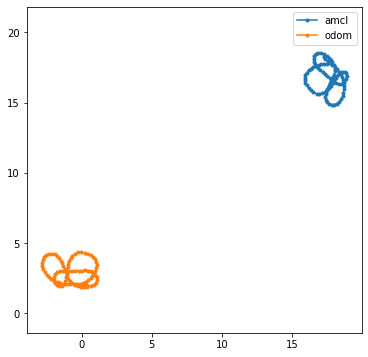

In [3]:
ground_truth = np.array([translation_from_matrix(d.ground_truth) for d in data])
measurement = np.array([translation_from_matrix(d.measurement) for d in data])

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ground_truth[:, 0], ground_truth[:, 1], '.-', label='amcl')
ax.plot(measurement[:, 0], measurement[:, 1], '.-', label='odom');
ax.legend();
ax.axis('equal');

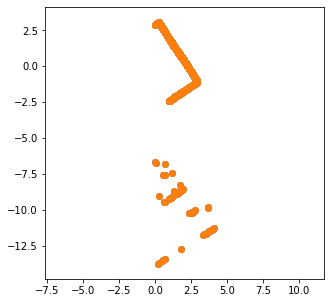

In [4]:
scan0 = np.array(list(read_points(data[0].scan, field_names=('x', 'y'))))
scan4 = np.array(list(read_points(data[4].scan, field_names=('x', 'y'))))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scan0[:,0], scan0[:,1])
ax.scatter(scan0[:,0], scan0[:,1])
ax.axis('equal');

converged: True
estimate: <PointCloud of 450 points>
trans: [-0.658249  -0.3427594  0.       ]
rot: (0.0, -0.0, 0.10628120398859663)
fitness: 0.25207975352129625


<ipython-input-16-fe0a8b7346b7>:7: DeprecationWarning: Non length-one string passed in for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  converged, transf, estimate, fitness = icp.icp(p0, p4)


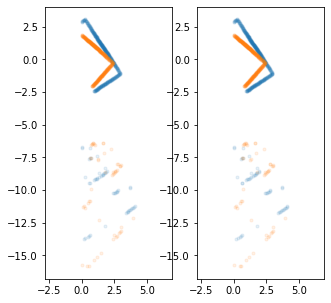

In [16]:
p0 = PointCloud()
p0.from_list(list(read_points(data[0].scan, field_names=('x', 'y', 'z'))))
p4 = PointCloud()
p4.from_list(list(read_points(data[4].scan, field_names=('x', 'y', 'z'))))

icp = p0.make_IterativeClosestPoint()
converged, transf, estimate, fitness = icp.icp(p0, p4)
print('converged:', converged)
print('estimate:', estimate)
print('trans:', translation_from_matrix(transf))
print('rot:', euler_from_matrix(transf))
print('fitness:', fitness)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(scan0[:,0], scan0[:,1], '.', alpha=0.1)
ax.plot(scan4[:,0], scan4[:,1], '.', alpha=0.1)
ax.axis('equal');

ax = fig.add_subplot(1, 2, 2)
ax.plot(estimate.to_array()[:,0], estimate.to_array()[:,1], '.', alpha=0.1)
ax.plot(scan4[:,0], scan4[:,1], '.', alpha=0.1)
ax.axis('equal');